In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

sns.set()
%matplotlib inline

In [36]:
leads = pd.read_csv('./brazilian-ecommerce/olist_marketing_qualified_leads_dataset.csv',
                    parse_dates=['first_contact_date'])
closed = pd.read_csv('./brazilian-ecommerce/olist_closed_deals_dataset.csv')

# EDA

## First Contact

In [37]:
test = leads.assign(dummy=1)\
            .pivot_table(columns='origin', index='first_contact_date', aggfunc='sum')\
            .fillna(0)\
            .resample('M')\
            .sum()

In [38]:
test.columns = test.columns.get_level_values(1)

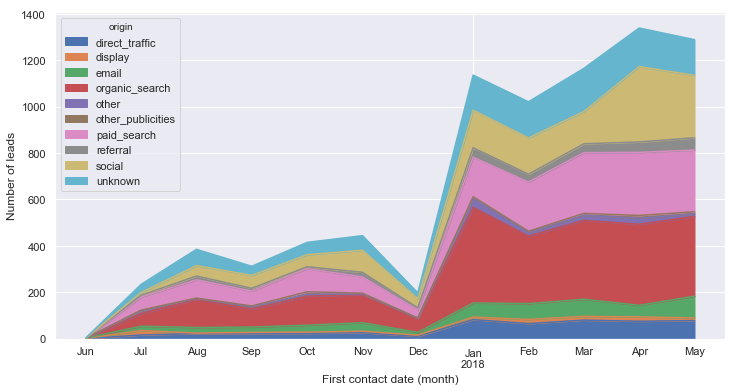

In [39]:
test.plot.area(figsize=(12,6));
plt.ylabel('Number of leads')
plt.xlabel('First contact date (month)');

## Landing Page

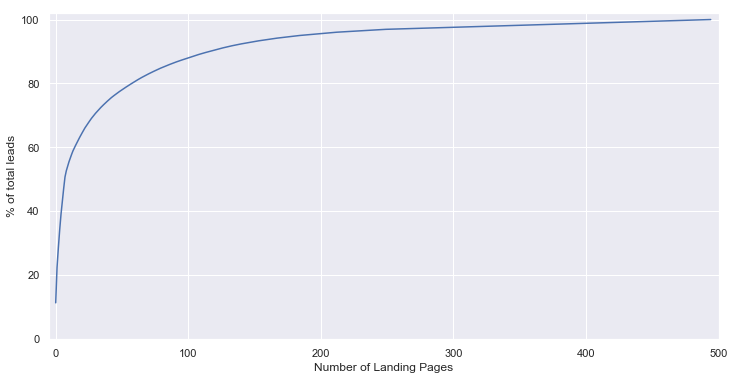

In [40]:
cumulative_pct_landing = leads.landing_page_id.value_counts(normalize=True).cumsum() *100
cumulative_pct_landing.reset_index(drop=True).plot.line(figsize=(12,6));
plt.xlabel('Number of Landing Pages')
plt.ylabel('% of total leads')
plt.xlim((-5,500))
plt.ylim((0,102));

## closed deals

Success rate of origins = number of closed / number of leads

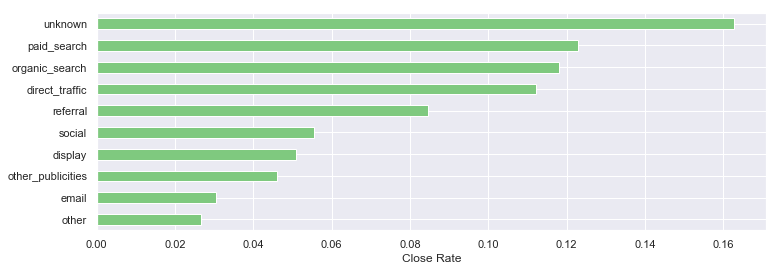

In [41]:
origin_success_rate = closed.merge(leads, how='left', on='mql_id')\
                            .origin.value_counts() / leads.origin.value_counts()
origin_success_rate.sort_values(ascending=True).plot.barh(figsize=(12,4), cmap='Accent')
plt.xlabel('Close Rate');

Find the best landing pages by their success (close) rate:

In [42]:
closed_landings = closed.merge(leads, how='left', on='mql_id')\
                        .landing_page_id.value_counts()
lead_landings = leads.landing_page_id.value_counts()

In [43]:
top_landings_byrate = pd.DataFrame({'num_closed': closed_landings,
                                    'rate_closed': closed_landings/lead_landings[closed_landings.index]})
# choose minimum number of closed merchants at 10 arbitrarily
top_landings_byrate.loc[top_landings_byrate.num_closed >= 10]\
                    .sort_values(by='rate_closed', ascending=False)

,num_closed,rate_closed
30077c17f2ec5010a82e37ad8925b95f,10,0.208333
40dec9f3d5259a3d2dbcdab2114fae47,67,0.203030
22c29808c4f815213303f8933030604c,174,0.197055
b76ef37428e6799c421989521c0e5077,171,0.187500
7fa6214d82e911d070f51ef79381b956,11,0.161765
ce1a65abd0973638f1c887a6efcfa82d,59,0.149746
241f79c7a8fe0270f4fb79fcbbcd17ad,14,0.128440
a7982125ff7aa3b2054c6e44f9d28522,18,0.115385
88740e65d5d6b056e0cda098e1ea6313,31,0.069663
f017be4dbf86243af5c1ebed0cff36a2,21,0.067742


These could be landing pages to focus on increasing the lead volume.

# Segmentation of leads

**Objective:** Identify merchants most likely to close, based on lead attributes.

**Method:** Use logistic regression to determine how each landing_page and origin affect closing.

In [44]:
# engineered features
leads['month'] = leads.first_contact_date.dt.month
leads['dayofweek'] = leads.first_contact_date.dt.dayofweek # Monday=0, Sunday=6

# merge with closed dataset to get merchants who converted
leads = leads.merge(closed[["seller_id", "mql_id"]], how="left", on="mql_id")

# engineer label and features
top_landings_byvol = lead_landings.head(50).index # top 10% of landing pages
leads['closed'] = np.where(leads.seller_id.isna(), 0, 1)
leads = leads.drop(columns=['mql_id', 'first_contact_date', 'seller_id'])
leads.landing_page_id = leads.landing_page_id.where(leads.landing_page_id.isin(top_landings_byvol), 
                                                    'others')

In [90]:
X = pd.get_dummies(leads.drop(columns=['closed']),
                   columns=['landing_page_id', 'origin', 'dayofweek', 'month'],
                   drop_first=True)
y = leads['closed']

Check for collinearity:

In [91]:
X.columns[(X.corr() > 0.3).sum() > 1] # correlated features

Index(['landing_page_id_58326e62183c14b0c03085c33b9fdc44',
       'landing_page_id_73f31a40697cc90a86c1273563ac230e',
       'landing_page_id_88740e65d5d6b056e0cda098e1ea6313',
       'landing_page_id_b76ef37428e6799c421989521c0e5077', 'origin_other',
       'origin_social', 'origin_unknown'],
      dtype='object')

In [92]:
X = X.drop(columns=['landing_page_id_58326e62183c14b0c03085c33b9fdc44',
                    'landing_page_id_73f31a40697cc90a86c1273563ac230e',
                    'landing_page_id_88740e65d5d6b056e0cda098e1ea6313',
                    'landing_page_id_b76ef37428e6799c421989521c0e5077'])

In [93]:
X.columns[(X.corr() > 0.3).sum() > 1]

Index([], dtype='object')

In [94]:
y.value_counts() # highly skewed

0    7158
1     842
Name: closed, dtype: int64

Use upsampling strategy to correct for class imbalance:

In [95]:
n_upsampled = int((y==0).sum()/2) # 3579

In [96]:
X_ = X[y==1].sample(replace=True, n=n_upsampled, random_state=12345)
y_ = pd.Series([1] * n_upsampled)

X = X.append(X_, ignore_index=True)
y = y.append(y_, ignore_index=True)

Build model:

In [97]:
model = sm.Logit(y.T, sm.tools.add_constant(X, prepend=True))

In [98]:
# grid search for best fit model using aic
best_alpha = 0
best_aic = 1e9
for a in np.logspace(0, 2, num=30):
    results = model.fit_regularized(disp=False, method='l1', alpha=a)
    if results.aic < best_aic:
        best_alpha = a
        best_aic = results.aic

QC check did not pass for 3 out of 73 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
QC check did not pass for 1 out of 73 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


In [99]:
best_aic, best_alpha

(13417.062793761368, 1.0)

In [100]:
results = model.fit_regularized(disp=False, method='l1', alpha=round(best_alpha, 1))
results.summary()

QC check did not pass for 3 out of 73 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                11579
Model:                          Logit   Df Residuals:                    11506
Method:                           MLE   Df Model:                           72
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.1382
Time:                        13:14:20   Log-Likelihood:                -6635.5
converged:                       True   LL-Null:                       -7699.4
                                        LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -0.1911      0.113     -1.688      0.091      -0.413       0.031
landing_page_id_0218f6be0b76aca72ab4d00ee9e8cf10    -0.1255      0.253     -0.496      0.620      -0.622       0.370
landing_page_id_0b37d43dbde6452cdd94c17bf61a88e4    -2.9866      1.024     -2.915      0.004      -4.994      -0.979
landing_page_id_15cf89bab2c3163b4f9d8601d108f8b2    -1.0487      0.385     -2.722      0.006      -1.804      -0.293
landing_page_id_1722481ac9e5371e5099dea226b5421d    -0.5077      0.316     -1.608      0.108      -1.127       0.111
landing_page_id_1ceb590cd1e00c7ee95220971f82693d    -0.2547      0.213     -1.197      0.231      -0.672       0.162
landing_page_id_21a104c3279681d9856b8a48723c4fee    -0.0834      0.288     -0.290      0.772      -0.647       0.480
landing_page_id_22c29808c4f815213303f8933030604c     0.5551      0.080      6.918      0.000       0.398       0.712
landing_page_id_241f79c7a8fe0270f4fb79fcbbcd17ad     0.0145      0.179      0.081      0.935      -0.335       0.364
landing_page_id_27cd3540bace1f4a4b2bc6d319b0553c    -0.5971      0.358     -1.669      0.095      -1.298       0.104
landing_page_id_30077c17f2ec5010a82e37ad8925b95f     0.6803      0.231      2.945      0.003       0.227       1.133
landing_page_id_30534107aa0013db92899c96a1017d0b    -2.6596      1.017     -2.616      0.009      -4.653      -0.667
landing_page_id_330b9d44078a1ae5a221d655dcb77afa    -1.3093      0.342     -3.832      0.000      -1.979      -0.640
landing_page_id_35c9b150ab36fe584c1f24fd458c453a    -0.2189      0.233     -0.938      0.348      -0.676       0.238
landing_page_id_36120633c8737035fbabf079082f4ec1    -1.0480      0.280     -3.744      0.000      -1.597      -0.499
landing_page_id_3cd2a8301d5395f21cdd3094c9eaa2f4    -0.4668      0.556     -0.840      0.401      -1.556       0.622
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47     0.3621      0.108      3.361      0.001       0.151       0.573
landing_page_id_4aab772aeb9833c170d8ea5413e02eac    -0.0661      0.328     -0.202      0.840      -0.708       0.576
landing_page_id_4e82dd1f6d00626bda0723eef0a269a6    -1.3629      0.499     -2.729      0.006      -2.342      -0.384
landing_page_id_5dc848e7dd9418dffe183215b8ff0bc1    -0.4083      0.283     -1.445      0.148      -0.962       0.145
landing_page_id_649b7b8b46b254497e92038d88f6ced8    -0.2016      0.266     -0.759      0.448      -0.723       0.319
landing_page_id_65d9f9d71e562365e8b44037c2888d98    -0.9430      0.246     -3.834      0.000      -1.425      -0.461
landing_page_id_73fec6021437e723ff5adae8dff89e23    -0.4544      0.443     -1.025      0.305      -1.323       0.415
landing_page_id_7fa6214d82e911d070f51ef79381b956     0.3702      0.205      1.806      0.071      -0.032       0.772
landing_page_id_87732658ba41d8775e8577df347a64db  2.689e-17      0.409   6.58e-17 

No feature selection done. Refit model with significant features only:

In [108]:
# recursively trim model for insignificant features
while (results.pvalues > 0.05).sum() > 0:
    X = X.loc[:, (results.pvalues < 0.06)] # some buffer
    model_trim = sm.Logit(y, sm.add_constant(X, prepend=True))
    results = model_trim.fit(disp=0, maxiter=200)

C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [128]:
print("model AIC = %.2f" % results.aic)
print(results.summary())

model AIC = 13583.33
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                11579
Model:                          Logit   Df Residuals:                    11548
Method:                           MLE   Df Model:                           30
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.1219
Time:                        13:31:00   Log-Likelihood:                -6760.7
converged:                       True   LL-Null:                       -7699.4
                                        LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -0.1899      0.046     -4.131      0.000      -0.280      -0.

Error Analysis:

In [139]:
# confusion matrix
print("Confusion Matrix")
print("=================")
print("Obs |   Predicted")
print(pd.DataFrame(results.pred_table(threshold=0.5)).to_string())

Confusion Matrix
Obs |   Predicted
        0       1
0  5552.0  1606.0
1  2085.0  2336.0


In [127]:
np.sum(np.diag(results.pred_table())) / X.shape[0] # accuracy

0.6812332671215131

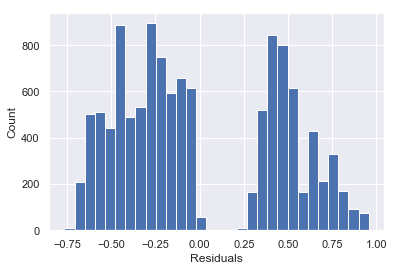

In [140]:
plt.hist(results.resid_response, bins=30);
plt.xlabel('Residuals')
plt.ylabel('Count');

## identify landing pages with better than origin-average rates of conversion

i.e. Which landing pages work better with which channel origins?

In [149]:
lead_table = leads.pivot_table(index='landing_page_id',
                               columns='origin',
                               values='closed',
                               aggfunc='mean').fillna(0)\
                  .filter(items=top_landings_byvol, axis='index')

In [150]:
origin_success_rate

direct_traffic       0.112224
display              0.050847
email                0.030426
organic_search       0.118031
other                0.026667
other_publicities    0.046154
paid_search          0.122951
referral             0.084507
social               0.055556
unknown              0.162875
Name: origin, dtype: float64

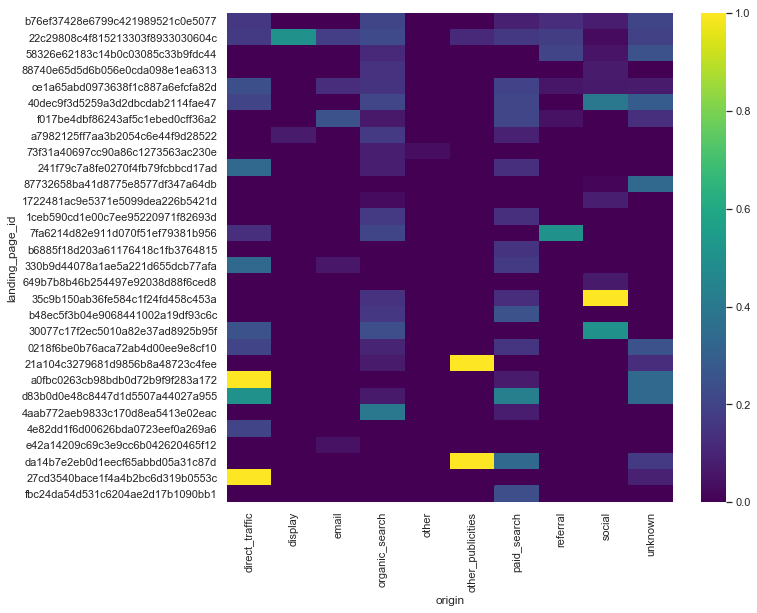

In [151]:
origin_leaders = (lead_table.apply(lambda x: x > origin_success_rate[x.name])
                            .sum(axis=1) > 0)

plt.figure(figsize=(10,9))
sns.heatmap(lead_table[origin_leaders], cmap='viridis');

## Conversion rate if we only used the origin leaders

Conversion rate threshold set at 0.2 arbitrarily

In [186]:
target_combos = lead_table[origin_leaders].unstack()\
                                          .where(lambda x: x >= 0.2)\
                                          .dropna().reset_index()

In [187]:
target_combos.head()

,origin,landing_page_id,0
0,direct_traffic,ce1a65abd0973638f1c887a6efcfa82d,0.239130
1,direct_traffic,40dec9f3d5259a3d2dbcdab2114fae47,0.200000
2,direct_traffic,241f79c7a8fe0270f4fb79fcbbcd17ad,0.333333
3,direct_traffic,330b9d44078a1ae5a221d655dcb77afa,0.333333
4,direct_traffic,30077c17f2ec5010a82e37ad8925b95f,0.250000


In [195]:
# get all rows that match both origin and landing page pairs
target_combo_results = leads.merge(target_combos.drop(columns=[0]).drop_duplicates())
# conversion rate
print("new conversion rate: ", target_combo_results.closed.sum() / target_combo_results.shape[0])
print("number of leads: ", target_combo_results.shape[0])

new conversion rate:  0.22123893805309736
number of leads:  1808


In [196]:
# original conversion rate
print("new conversion rate: ", leads.closed.sum() / leads.shape[0])
print("number of leads: ", leads.shape[0])

new conversion rate:  0.10525
number of leads:  8000
